## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
import email
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-06-14 19:30:01.622279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 19:30:01.622419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 19:30:01.755018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7ccb32f0-0e07-42eb-7370-6b9b797c3231)
GPU 1: Tesla T4 (UUID: GPU-9aee948d-b8c5-041e-5c6d-d01a6b700ec4)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
len(phishing_messages_1)

3976

In [6]:
phishing_messages_1[500]

"From: J. Rodney Chesson \nChesson Family Corporation,\nLiberia.\nEmail: jrchesson@rediffmail.com\n\nKindest attention,\n\nI am very sorry for the informal manner in which this mail is reaching you. This is necessitated by my urgent need to reach a dependable and trustworthy foreign partner. This request may seem strange and unsolicited but I crave your indulgence and pray that you take my request very serious.\n\nI am Mr. J. Rodney Chesson, the first son of Late J. J. F. Chesson (Liberian Minister of Justice 1979 to 1980). On April 22, 1980, my father along with 12 other Liberian Government officials was assassinated as a result of a military coup that toppled the government of President William\nR. Tolbert, Jr. May his soul rest in Eternal Peace. Since then, my family has always been seen as a symbol of peace in Liberia. \n\nI received information from a reliable source that described your country as being economically conducive for investment and her people as transparent and trustw

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
ham_messages[5]

'\n[can\'t think of how I\'d be running\nafoul of the spam filters with this\npost, so here\'s the second try...]\n\nKissinger\'s book _Does America Need\na Foreign Policy?_ provides a few\nhandy abstractions:\n\n> The ultimate dilemma of the statesman is to strike a balance between\n> values ["idealism"] and interests ["realism"] and, occasionally,\n> between peace and justice.\n\nAlso, he views historical American\napproaches to foreign policy as a\nbundle of three fibers:\n\nHamiltonian - We should only get\n  involved in foreign adventures\n  to preserve balances of power.\n\nWilsonian - We should only get\n  involved in foreign adventures\n  to further democracy, etc.\n\nJacksonian - We should never get\n  involved in foreign adventures.\n  Unless we\'re attacked.  Then we\n  go Rambo.\n\nHe has tactfully left out the hard\nrealists*; as for the rest I gather\nwilsonians play the idealists, and\nhamiltonians act where values and\ninterests intersect, and jacksonians \nact only whe

In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
phishing_messages_2[:5]

['<html>\n\n<head>\n<meta http-equiv="Content-Language" content="en-us">\n<meta name="GENERATOR" content="Microsoft FrontPage 5.0">\n<meta name="ProgId" content="FrontPage.Editor.Document">\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n<title>Norton AD</title>\n</head>\n\n<body>\n\n<table border="3" cellspacing="3" width="469" cellpadding="3" bgcolor="#000080"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#FFFFFF">\n  <tr>\n    <td width="447">&nbsp;\n      <table border="1" width="100%" bgcolor="#FFFFFF" bordercolor="#000080">\n        <tr>\n          <td width="100%" align="center"><font face="Impact" size="4" color="#CC0000">ATTENTION:\n            This is a MUST for <u>ALL</u> Computer Users!!!</font></td>\n        </tr>\n      </table>\n      <p align="center"><font size="3" face="Verdana"><b>&nbsp;<font color="#FFFFFF">*NEW\n      - Special Package Deal!*</font></b></font></p>\n      <table border="8" width="100%" height=

In [11]:
## getting meassages from html like messages 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
phishing_messages_3[0]

"Norton AD\n\n\n\n\n\n\n\n\n\n\n\xa0\n      \n\n\n\n\nATTENTION:\n            This is a MUST for \nALL\n Computer Users!!!\n\n\n\n\n\n\n\xa0\n*NEW\n      - Special Package Deal!*\n\n\n\n\n\n\nNorton\n            SystemWorks 2002 Software Suite\n\n            -\nProfessional Edition\n-\n\n\n\n\n\n\n\n\n\n\nIncludes\n            Six - \nYes 6!\n - Feature-Packed Utilities\nALL\n            for \n1\n\n            Special \nLOW\n\n            Price!\n\n\n\n\n\n\n\n\n\n\nThis Software Will:\n- Protect your\n            computer from unwanted and \n hazardous\n viruses\n- Help secure your\n            private & valuable information\n- Allow you to transfer files\n            and send e-mails \n safely\n- Backup your ALL your data quick and\n            easily\n- Improve your PC's performance w/\nsuperior\n\n            integral diagnostics!\n\n\n\n\n\xa0\n      \n\n\n\n\n\n\n6\n\n\nFeature-Packed Utilities\n\n\n1\n\n\n Great\n            Price\n \n\n\n\n            A\n \n$300+\n \n Combined 

In [13]:
## removing \n  from phishing_messages_3
phishing_messages_4=[]
for ph_message in phishing_messages_3 : 
    cleaned=ph_message.replace('\n','')
    phishing_messages_4.append(cleaned)

In [14]:
phishing_messages_4[0]

"Norton AD\xa0      ATTENTION:            This is a MUST for ALL Computer Users!!!\xa0*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!\xa0      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect\xa0 your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW

In [15]:
## removing \xa0  from phishing_messages_3

phishing_messages_5=[]
for ph_message in phishing_messages_4 : 
    cleaned=ph_message.replace('\xa0','')
    phishing_messages_5.append(cleaned)
    

In [16]:
phishing_messages_5[0]

"Norton AD      ATTENTION:            This is a MUST for ALL Computer Users!!!*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW! <-Click      h

In [17]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)}')

# Optional: Print the first message to check


Total messages extracted from  emails-enron-legal-mails.mbox : 4279


In [18]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


Vicky,

Sounds like they've been working you to hard.  You certainly deserve a vacation.  I would like to hear about your adventures overseas.  My address is as follows:


			Andy Lewis
			3131 Timmons Ln
			Apt. 1010	
			Houston, TX  77027



I got a letter from Diem with their new London address.  I figure I'll give them a month or so to move in  before I look into visiting.  Of course, getting time off in this job is easier said than done.  Anyway, enjoy your trip, and I look forward to hearing from you.

-Andy

 


 ####################################################################################################
Thanks for your note.  Agreed that execution on IMI and II (construction, debt and equity closings) are the key for the Americas.  It looks like we will have slippage for Q2; I am expecting to see European numbers later this morning and will give you a call to discuss on Friday.  We can also discuss the gearbox issues for the US as to which I am a bit more optimistic tha

In [19]:
# legal_emils[600:605]

In [20]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# Example usage with the email samples
# cleaned_emails = extract_and_clean_emails(emails)
# print(cleaned_emails)
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [21]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

PGE has informed us that they have a couple of voice mail cards that are down.

WHAT THIS MEANS:

If a call that is going to voice mail hits one of these cards, the call will continue to ring without ever getting to voice mail. 

This is a random event as calls get routed to cards based on availability.

If this happens, the party would have to call back and try again, or get a hold of your admin to leave a written message.


THE FIX:

PGE will have cards here in the morning and will replace them on Saturday.  They are waiting to do this because it will require a system wide outage of voicemail.

The repair is currently scheduled for this Saturday, 10:00 PST and should last no more than 2 hours.


Please let me know if you have any questions.

Regards

Dave 

 ####################################################################################################
Cc: christopher.calger@enron.com, james.steffes@enron.com, lysa.akin@enron.com
Mime-Version: 1.0
Content-Type: text/plain; chars

### Getting phishing emails from  emails-phishing-nazario.mbox

In [22]:


# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of messages: {len(phishing_nazario_messages)}")




Number of messages: 2279


In [23]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that causes Unicodeerror')


removed 141 messages that causes Unicodeerror


In [24]:
len(cleaned_phishing_nazario_messages)

2138

In [25]:
# let's have a look on sample of cleaned_phishing_nazario_messages
for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

Return-Path: <operator_6971700ib@bbt.com>
Delivered-To: user@example.com
Received: from mail.example.com (mail.example.com [192.168.6.4])
	by example.com (Postfix) with ESMTP id 797BD2A893
	for <user@example.com>; Fri, 23 Mar 2007 13:04:15 -0500 (EST)
Received: by mail.example.com (Example mail relay)
	id 6C73A621D68; Fri, 23 Mar 2007 14:04:15 -0400 (EDT)
Delivered-To: user@example.com
Received: from 192.168.6.4 (unknown [59.22.91.175])
	by mail.example.com (Example mail relay) with SMTP id 41110621D65
	for <user@example.com>; Fri, 23 Mar 2007 14:04:13 -0400 (EDT)
Received: from hillbilly.all.bg (all.bg.iwarp.com [112.168.80.146])
         by sexcounter.com with SMTP id GWCOB06E1S
         for <user@example.com>; Fri, 23 Mar 2007 10:04:02 -0800
From: "Branch Banking and Trust" <operator_6971700ib@bbt.com>
To: user <user@example.com>
Subject: BB&T: security maintenance! -Fri, 23 Mar 2007 10:04:02 -0800
Date: Fri, 23 Mar 2007 22:02:02 +0400
X-Mailer: Mutt/1.5.1i
X-Priority: 3 (Normal)
MI

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [26]:

# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)

print(len(cleaned_phishing_nazario_messages_text))


2116


In [27]:
cleaned_phishing_nazario_messages_text[:5]

['in 1841 stars battle    Tour de France in 1872 in 1923 \n\nR0lGODlhZQJsAfPrAAkFAKbK8ICAgABgwACAwCCAwECAwECgwGCgwICgwIDAwP/78AAA/////wAAAAAAACH5BAQAAAAALAAAAABVAmMBAAT/sMlJq7046827/2AojmRpnmiqrmzrvnAsz3Rt33iu73zv/8CgcEgs\nGo/IpHLJbDqf0Kh0Sq1ar9isdsvter+dhXhMLpvFgYACQQC73/C4/BpAFAiDvH7P7/fngIGCg4QxAQV+\niYp9BYWOj5ApdXcEBAUGCQtFC2mdaRaeoaKhUwmLp6cIkausrRcBBouqQwF9BhZ4qHy3Uaa6v3wBrsPE\njrWovDd2BcyXwg3He8kTucAD0zkJBtvczxrR1r/YxeTlXwvVqTiIwRLgeePp4j2x7Rro4dbe5vz9WAj6\nbsgb8OzdNVz5xt2ot2ffBV/5dM3yR7EiFHzAFMIYWNAWwnAa/2sw1OPQAruIp0JaXMkyiMEBCNKc3KOp\nBkd3HisMREavT0kKL1HuqtmyqNEfEPU0wunTxk1oOSkg4LbNDwGqmHrawxBU6AACP4+KHTsDIJ+JDWbm\nSVAhTQIECBQEIGriqUFeC97GBOoHrQVObE+ogZtg7oWRecJKMOtVz1XDZCNLjoEYJoXKExPsvPZsgYFm\nzAzUPAR6GzM/oRnruaX6a8c+qpY1YxsADwHZzQqCZha4wQI2fgwUhDvQANyfnEYpXy5msvPnLVp/JSqd\nrWdUwhb4qSldV+WqfoS9VKVWuOPKr6UxlQVVHSjjcOPLn09ffmG60PPr95BUac0zElSWiP8w2y0WkYCK\nNDJeA/J8dl5T7anXFR+FoeKXBP01xtl+HHb4SiJgZTAhHwVo1wd3B4aTRl8MLnIVhHelBUx3Z11gooZn\n4efhjs9h1JeODQi42UsoJqTijXuoslkeL9pj0AE

In [28]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages

# Example usage:

cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)
# for cleaned_message in cleaned_messages:
#     print(cleaned_message)


In [29]:
## removing \n and 0x from meassages 
cleaned_phishing_nazario_messages_text_2=[]
for m in cleaned_phishing_nazario_messages_text_1 :
    m=m.replace('\n','')
    m=re.sub('[0x\d]+','',m)
    m=m.replace(',','')
    cleaned_phishing_nazario_messages_text_2.append(m)
    
    

In [30]:
cleaned_phishing_nazario_messages_text_2[:5]

['in  stars battle Tour de France in  in ',
 'Dear eBay User  After fraud complaints from the eBay members the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take  days period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. RegardsSafeharbor Department eBay Inc.',
 "Dear valued customer O

## Getting all data into a dataframe 

In [31]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [32]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_5+cleaned_phishing_nazario_messages_text_2
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,Dear PayPal Member Your account has been rando...
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,Dear eBay user eBay Customer Support Team requ...
8383,1,Dear PayPal Member Your account has been rando...


In [33]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [34]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email Blaster The program will send mai...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [35]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [36]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [37]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4645

In [38]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1964 duplicated phishing messages in data 


In [39]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [40]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [41]:
shuffled_df['phishing'].value_counts()

phishing
0    8545
1    6421
Name: count, dtype: int64

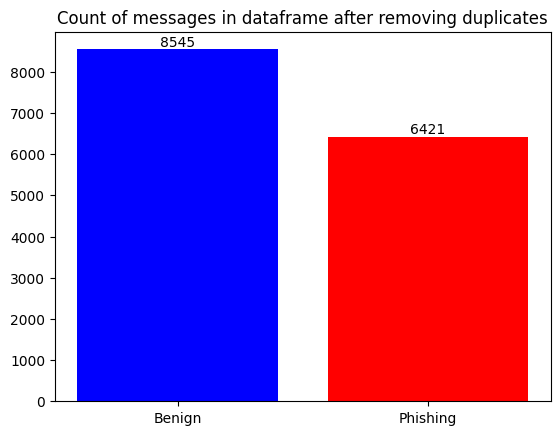

In [42]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [43]:

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6421 phishing messages and 8545 ham messages in data after removing Duplicates


In [44]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [45]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?If you do you will ma...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [46]:
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [47]:
train_labels.value_counts()

phishing
0    6824
1    5148
Name: count, dtype: int64

In [48]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 11972 message


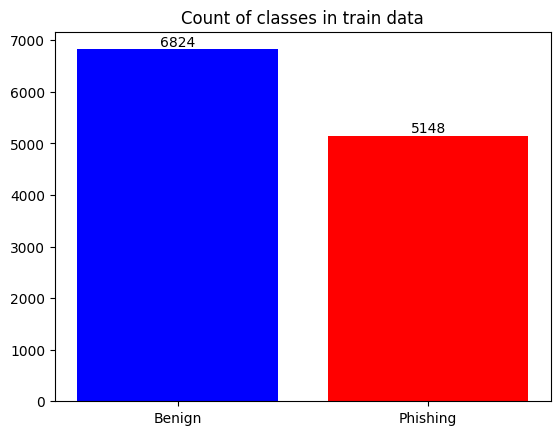

In [49]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [50]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 2994 message


In [51]:
print(test_labels.value_counts())


phishing
0    1721
1    1273
Name: count, dtype: int64


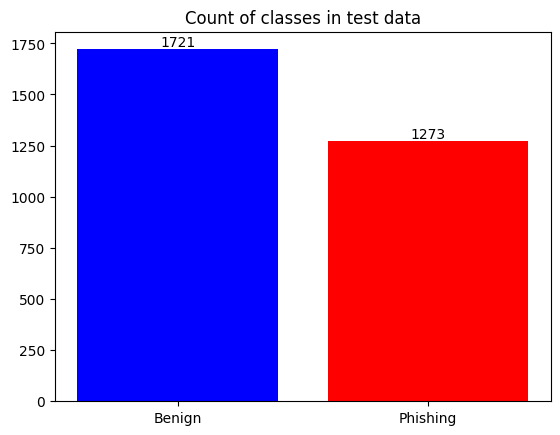

In [52]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [53]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [54]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[179,
 234,
 176,
 124,
 124,
 473,
 48,
 413,
 345,
 136,
 276,
 404,
 117,
 75,
 581,
 57,
 486,
 352,
 3,
 114,
 177,
 6,
 154,
 57,
 123]

In [55]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1082 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [56]:
## making Text vectorization layer 
## 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024)

In [57]:
text_vectorizer.adapt(train_text)

In [58]:
words_in_vocab=text_vectorizer.get_vocabulary()

In [59]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [60]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['dasbrandworldstdcom',
 'darveauxetsenronenron',
 'danmark',
 'dance',
 'damned',
 'dame',
 'dachshund',
 'czophyaolcom',
 'cuteftp',
 'cutaia',
 'curtail',
 'current2',
 'current1',
 'cunniffe',
 'critique',
 'crisatdtd',
 'crippling',
 'crenshawhouectect',
 'crawling',
 'craiggannettdwtcom']

In [61]:
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1183, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [62]:
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [63]:
embed(text_vectorizer([sentence]))[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.02218691, -0.03682123, -0.02747964, -0.01805689, -0.03918573,
       -0.0354938 ,  0.02450019, -0.00464524, -0.01051762, -0.03654083,
        0.02936623, -0.0027303 , -0.04759624, -0.00629397,  0.03855766,
       -0.00725047,  0.00769495, -0.02108362, -0.04943885,  0.04639225,
       -0.04419383, -0.00027896,  0.02594331,  0.00461753, -0.03513523,
        0.00265853, -0.04983348, -0.02024238, -0.00886576,  0.04514382,
       -0.01048111, -0.01675866,  0.04664538, -0.02057455,  0.00402812,
        0.04483135,  0.02134058, -0.03817504, -0.02965492,  0.02390113,
       -0.00896915,  0.04594704,  0.02423279, -0.00384642,  0.0413054 ,
        0.04628532,  0.00566615, -0.01108278,  0.03895973,  0.02970948,
       -0.04197161,  0.02892635, -0.03918564, -0.01373237, -0.02253726,
       -0.0033397 ,  0.0293611 , -0.01426203,  0.02062804,  0.00472224,
        0.02653411, -0.0041999 ,  0.0387022 , -0.01179329,  0.02264279,
        0.012941

## Satrting Experiments 

In [64]:
## creating functions for callbacks 
def create_checkpoint_callback(file_path):
    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=False,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return cnn_model_checkpoint_callback
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

## Long-Term Short Memory (LSTM) model  

In [65]:
import tensorflow as tf 

inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

> #### creating tensorboard , early stopping and checkpoint callpacks 

In [66]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [67]:
type(train_text)

pandas.core.series.Series

In [68]:
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6750 - loss: 0.5900 - val_accuracy: 0.9488 - val_loss: 0.3620
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9719 - loss: 0.1621 - val_accuracy: 0.9620 - val_loss: 0.1497
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9853 - loss: 0.0644 - val_accuracy: 0.9737 - val_loss: 0.1124
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9829 - loss: 0.0660 - val_accuracy: 0.9621 - val_loss: 0.1185
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9873 - loss: 0.0412 - val_accuracy: 0.9463 - val_loss: 0.2025
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9794 - loss: 0.0647 - val_accuracy: 0.9758 - val_loss: 0.1101
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9925 - loss: 0.0292 - val_accuracy: 0.9721 - val_loss: 0.0971
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9868 - loss: 0.0465 - 

In [69]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [70]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


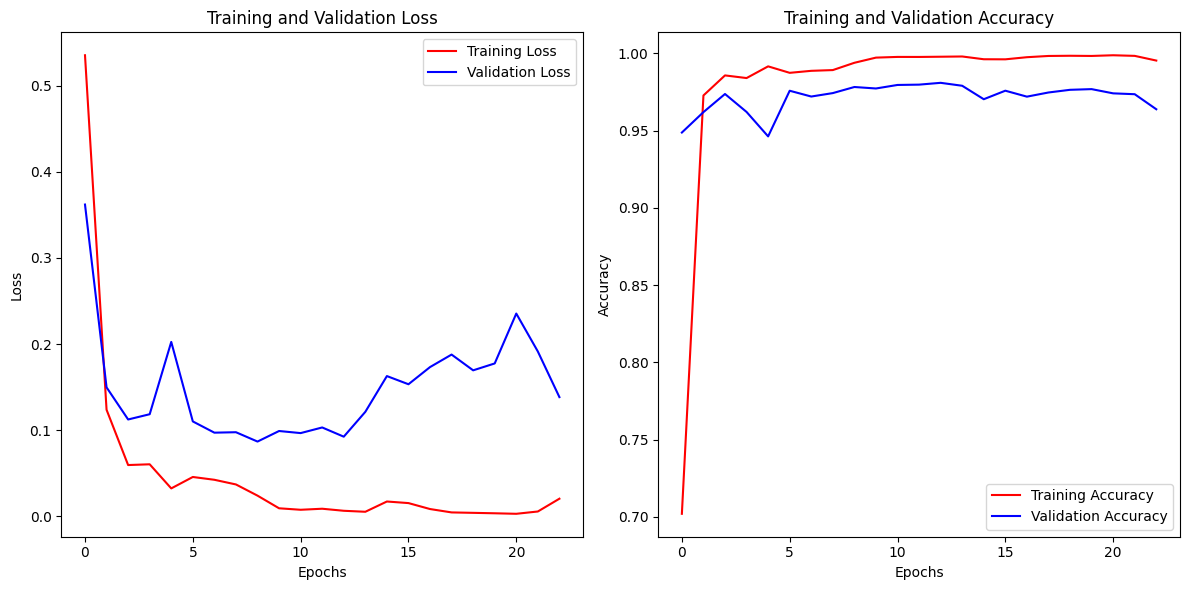

In [71]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [72]:
test_text.shape

(2994,)

In [73]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


(2994, 1024, 1)

In [74]:
import seaborn as sns

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [75]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to create other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [76]:
test_labels.shape

(2994,)

In [77]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

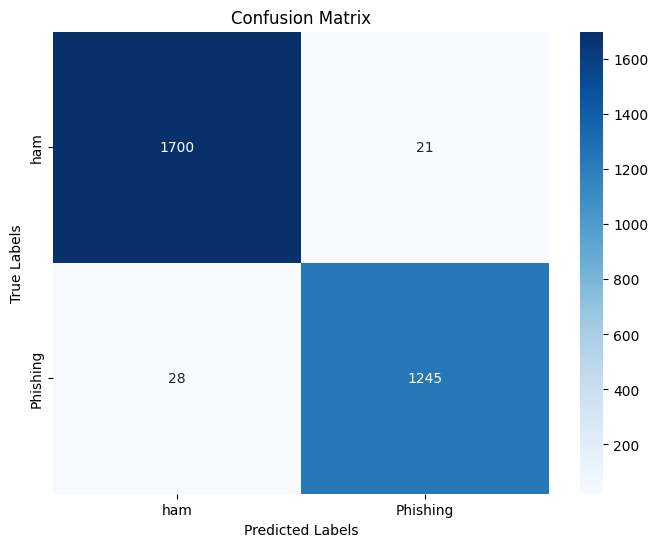

In [78]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [79]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.9836339345357381 

precision 0.9836330368008852 

recall 0.9836339345357381 

f1 0.9836279820573749 



In [80]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels.values,avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [81]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels.values,avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.016587677725118485 

False Negative Rate (FNR) 0.02199528672427337 

False Omission Rate (FOR) 0.016203703703703703 

False Positive Rate (FPR) 0.01220220801859384 

Negative Prediction Value (NPV) 0.9837962962962963 



### Creating tensorboard 
>##### to visualize tensorboard download tensorboards.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 

In [82]:
## zipping tensorbard directory to download it and visualize it on pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs


  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/train/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/train/events.out.tfevents.1718393632.b293b7aeb9e9.34.0.v2 (deflated 87%)
  adding: kaggle/working/logs/lstm_1/validation/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/events.out.tfevents.1718393652.b293b7aeb9e9.34.1.v2 (deflated 76%)


### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [83]:
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [84]:
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[-0.35357514 -0.19134405  0.4807192  ... -0.44278166 -0.2969703
  -0.04865436]
 [ 0.02171357 -0.11718901  0.02207528 ... -0.0509899   0.08423267
   0.05419185]
 [-0.05439758  0.00182348  0.03672359 ...  0.00719034 -0.01834684
  -0.12376621]
 ...
 [-0.02261879 -0.01392639 -0.00868733 ...  0.00728442 -0.0756036
  -0.07819263]
 [ 0.05930718  0.06876067 -0.03074979 ...  0.08992921  0.03691445
  -0.00418418]
 [ 0.00291648 -0.04862843 -0.03931508 ...  0.0228185   0.00898077
   0.01366987]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [85]:
import io
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [86]:
# Create 1-dimensional convolutional layer to model sequences
from keras import regularizers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 

outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
cnn_model.summary()


Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,689 (9.85 MB)

 Trainable params: 2,582,689 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [88]:
# fitting cnn model 
cnn_history=cnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9621 - loss: 0.2572 - val_accuracy: 0.9826 - val_loss: 0.0818
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9962 - loss: 0.0506 - val_accuracy: 0.9813 - val_loss: 0.0824
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9977 - loss: 0.0363 - val_accuracy: 0.9823 - val_loss: 0.0695
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9984 - loss: 0.0300 - val_accuracy: 0.9803 - val_loss: 0.0717
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9980 - loss: 0.0296 - val_accuracy: 0.9793 - val_loss: 0.0735
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0245 - val_accuracy: 0.9816 - val_loss: 0.0740
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9987 - loss: 0.0229 - val_accuracy: 0.9780 - val_loss: 0.0845
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9975 - loss: 0.0261 - val_accu

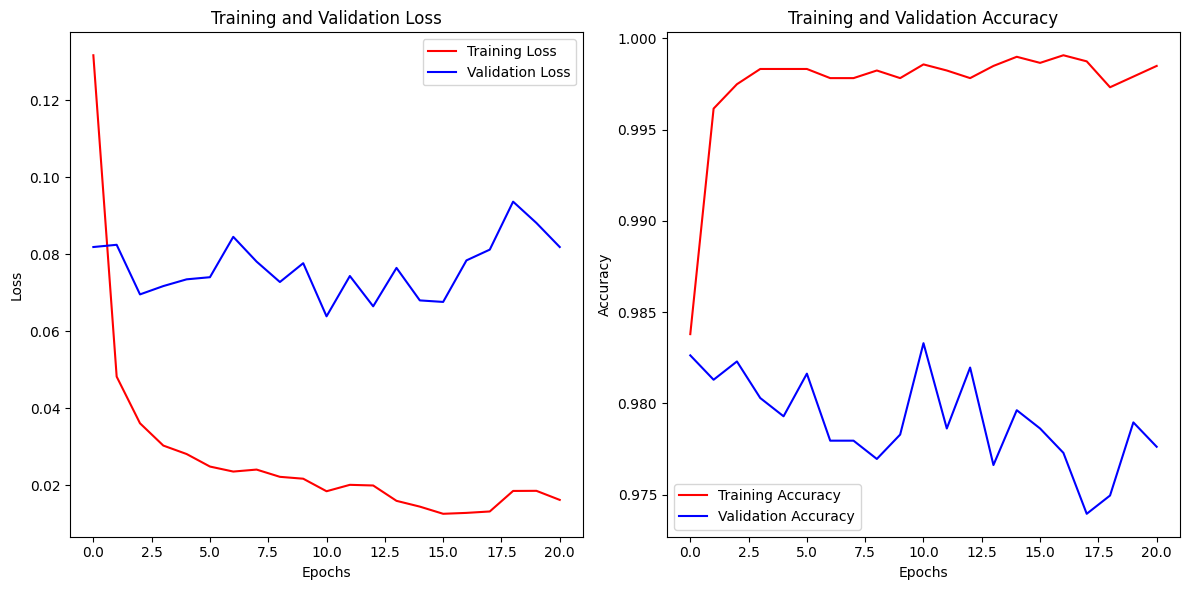

In [89]:
# plotting training curves for cnn model 


plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [90]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


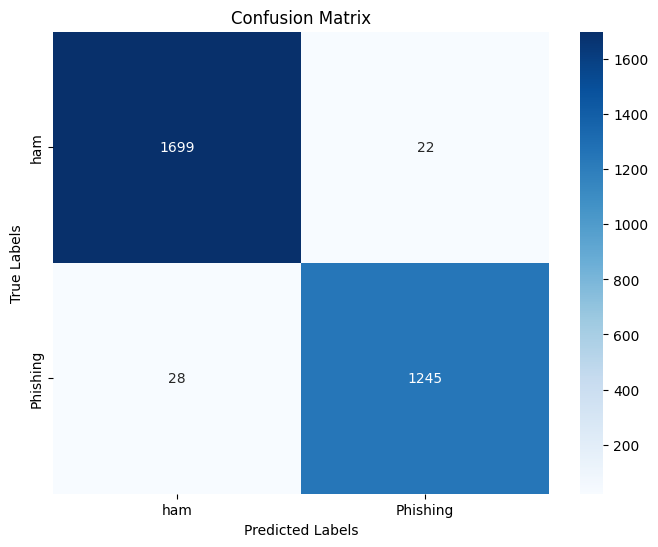

In [91]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [92]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9832999331997327, 'precision': 0.9833183941640233, 'recall': 0.9832999331997327, 'f1': 0.9833051274675457}


In [93]:
# classification report of  cnn_model  
report_2=classification_report(test_labels.values,avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [94]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.017363851617995266 

False Negative Rate (FNR) 0.02199528672427337 

False Omission Rate (FOR) 0.016213086276780544 

False Positive Rate (FPR) 0.012783265543288786 

Negative Prediction Value (NPV) 0.9837869137232195 



## GRU model 

In [95]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [97]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7294 - loss: 0.5048 - val_accuracy: 0.9704 - val_loss: 0.0919
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9746 - loss: 0.0917 - val_accuracy: 0.9790 - val_loss: 0.0724
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9908 - loss: 0.0316 - val_accuracy: 0.9802 - val_loss: 0.0690
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9948 - loss: 0.0156 - val_accuracy: 0.9813 - val_loss: 0.0781
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9963 - loss: 0.0097 - val_accuracy: 0.9803 - val_loss: 0.0805
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9971 - loss: 0.0080 - val_accuracy: 0.9821 - val_loss: 0.1041
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9811 - val_loss: 0.0817
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9960 - loss: 0.0105 - 

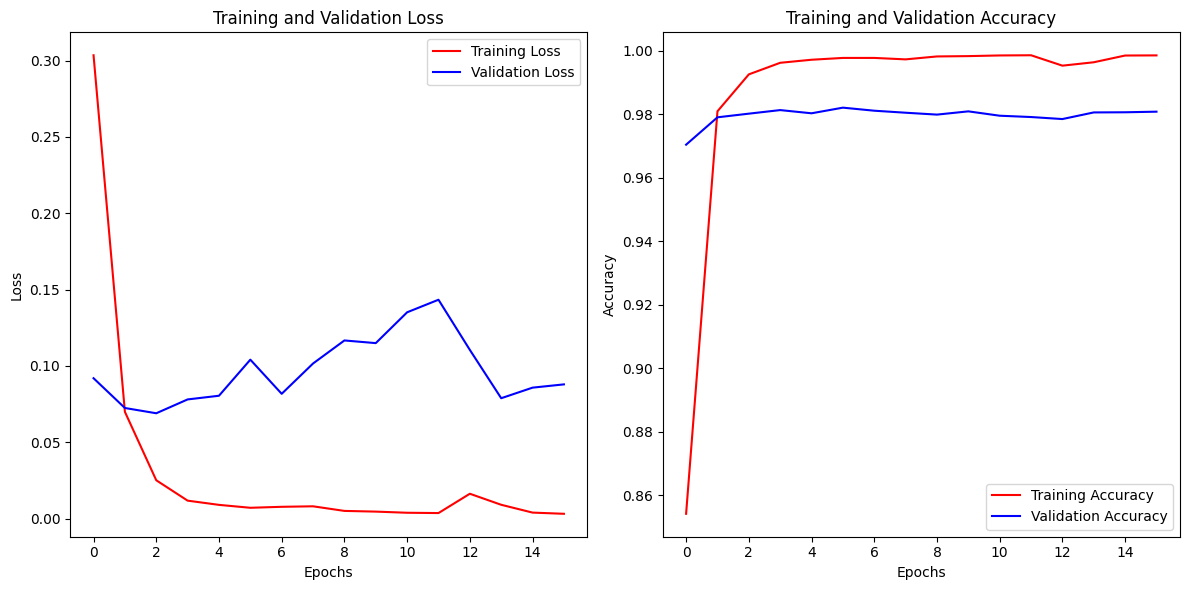

In [98]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [99]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


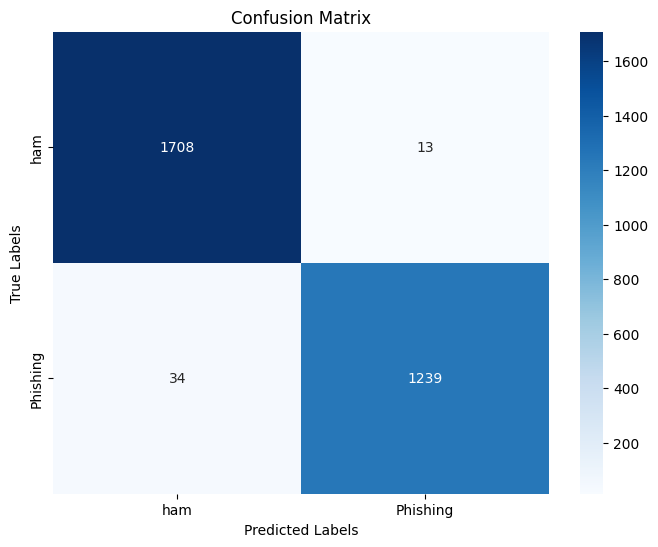

In [100]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [101]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.9843019372077488 

precision 0.9844362896149723 

recall 0.9843019372077488 

f1 0.9843196189202731 



In [102]:
# classification report of gru_model 
report_3=classification_report(test_labels.values,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.99      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [103]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.010383386581469648 

False Negative Rate (FNR) 0.02670856245090338 

False Omission Rate (FOR) 0.01951779563719862 

False Positive Rate (FPR) 0.007553747821034283 

Negative Prediction Value (NPV) 0.9804822043628014 



## SimpleRNN model

In [104]:
# # Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
# simplernn_model_embedding = layers.Embedding(input_dim=20000,
#                                      output_dim=128,
#                                      embeddings_initializer="uniform",
#                                      input_length=1024,
#                                      name="simple_rnn_embedding")

# # Build an RNN using the GRU cell
# inputs = layers.Input(shape=(1,), dtype="string")
# x = text_vectorizer(inputs)
# x = simplernn_model_embedding(x)
# x = layers.SimpleRNN(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   

# x = layers.Dense(64, activation="relu")(x) 
# outputs = layers.Dense(1, activation="sigmoid")(x)
# simple_rnn_model = tf.keras.Model(inputs, outputs, name="simple_rnn_model")
# simple_rnn_model.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])
# simple_rnn_model.summary()

In [105]:
# simple_rnn_model_history=simple_rnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
#             callbacks=[create_tensorboard_callback(file_path='logs/simple_rnn_model_tensorboard'),early_stopping_callback,
#                        create_checkpoint_callback(file_path='checkpoints/simple_rnn_model.keras')])

In [106]:


# plot_loss_and_accuracy_curves(simple_rnn_model_history)

### Evaluating SimpleRNN model


In [107]:
# pred_labels_simple_rnn_model=simple_rnn_model.predict(test_text.values)


In [108]:

# # Average over the time steps
# avg_pred_labels_simple_rnn_model = np.mean(pred_labels_simple_rnn_model, axis=1)

# avg_pred_labels_simple_rnn_model=np.round(avg_pred_labels_simple_rnn_model.flatten())
# simple_rnn_model_results=calculate_results(avg_pred_labels_simple_rnn_model,test_labels)
# print('Metrics for simple_rnn_model')
# for key,value in simple_rnn_model_results.items():
#     print(key,value,'\n')

In [109]:
# plot_confusion_matrix(y_pred=simple_rnn_model_results,y_true=test_labels.values)

In [110]:
# # calculating other metrices for simple_rnn_model
# print('Other metrics for simple_rnn_model\n')
# for key , value in calculate_metrics(test_labels.values,avg_pred_labels_simple_rnn_model).items():
    
#     print(key,value,'\n')

## Bidirectonal LSTM model 

In [111]:
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [112]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.8477 - loss: 0.3171 - val_accuracy: 0.9729 - val_loss: 0.0798
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9837 - loss: 0.0491 - val_accuracy: 0.9703 - val_loss: 0.0809
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9910 - loss: 0.0264 - val_accuracy: 0.9763 - val_loss: 0.0831
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9930 - loss: 0.0171 - val_accuracy: 0.9743 - val_loss: 0.0821
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9940 - loss: 0.0147 - val_accuracy: 0.9803 - val_loss: 0.0695
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9971 - loss: 0.0091 - val_accuracy: 0.9780 - val_loss: 0.0854
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9979 - loss: 0.0052 - val_accuracy: 0.9756 - val_loss: 0.0914
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9962 - loss: 0.0114 - 

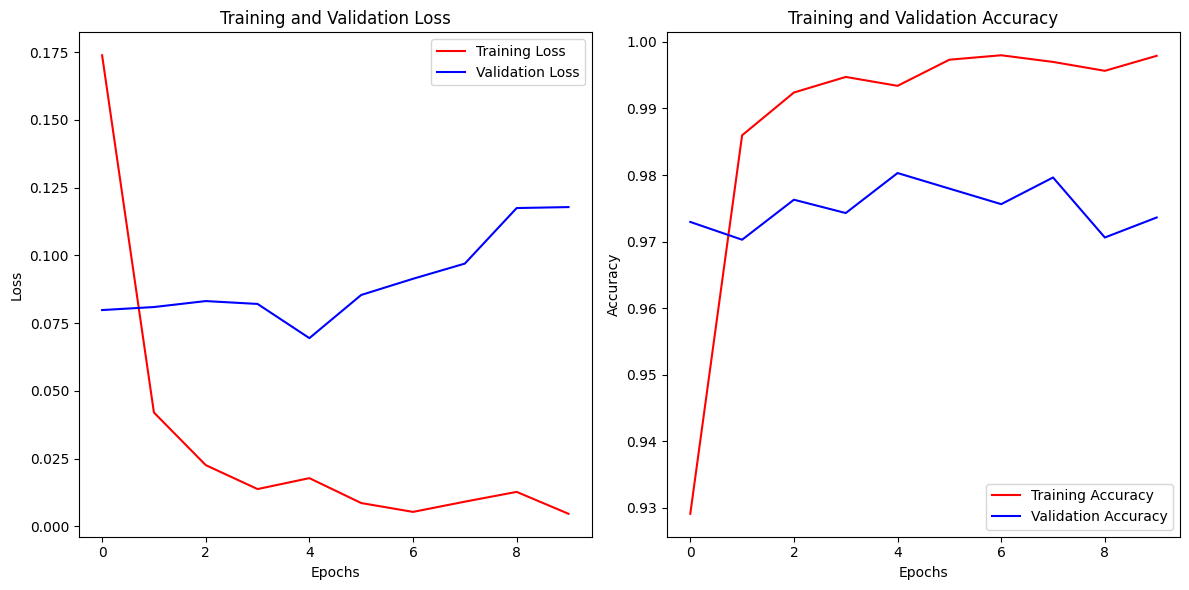

In [114]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [115]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [116]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9729458917835672 

precision 0.9729488861333146 

recall 0.9729458917835672 

f1 0.9729472780756868 



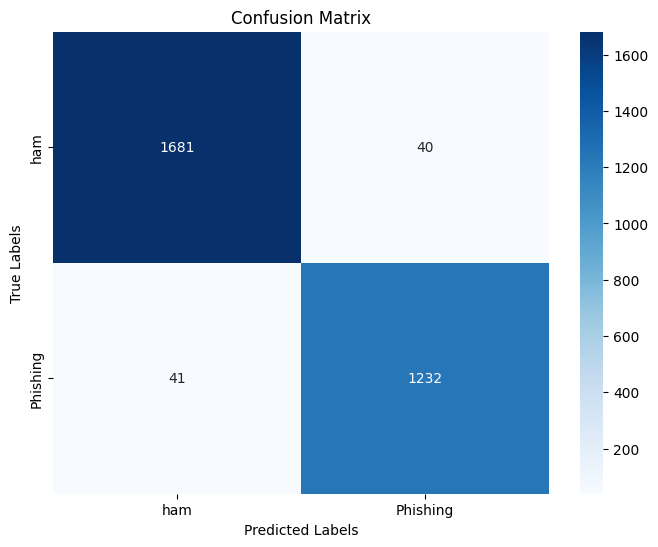

In [117]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

In [118]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels.values,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1721
           1       0.97      0.97      0.97      1273

    accuracy                           0.97      2994
   macro avg       0.97      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [119]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.031446540880503145 

False Negative Rate (FNR) 0.03220738413197172 

False Omission Rate (FOR) 0.023809523809523808 

False Positive Rate (FPR) 0.023242300987797792 

Negative Prediction Value (NPV) 0.9761904761904762 



## A simple dense model

In [120]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,129 (9.77 MB)

 Trainable params: 2,560,129 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [122]:
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6984 - loss: 0.5808 - val_accuracy: 0.9025 - val_loss: 0.3118
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8908 - loss: 0.2944 - val_accuracy: 0.9446 - val_loss: 0.2382
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9185 - loss: 0.2142 - val_accuracy: 0.9542 - val_loss: 0.2035
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9319 - loss: 0.1783 - val_accuracy: 0.9552 - val_loss: 0.1819
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9398 - loss: 0.1546 - val_accuracy: 0.9589 - val_loss: 0.1657
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9466 - loss: 0.1372 - val_accuracy: 0.9616 - val_loss: 0.1519
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9517 - loss: 0.1236 - val_accuracy: 0.9656 - val_loss: 0.1389
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9556 - loss: 0.1124 - val_accu

### Evaluating Dense model

In [123]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [124]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.9782899131596526 

precision 0.9782855580051678 

recall 0.9782899131596526 

f1 0.9782822709203285 



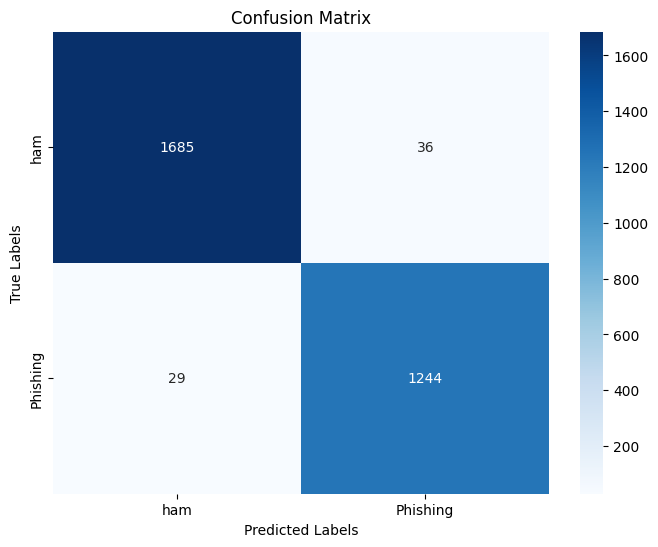

In [125]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels.values)

In [126]:
# classification report of dense_model 
report_5=classification_report(test_labels.values,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1721
           1       0.97      0.97      0.97      1273

    accuracy                           0.97      2994
   macro avg       0.97      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [127]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.028125 

False Negative Rate (FNR) 0.022780832678711706 

False Omission Rate (FOR) 0.01691948658109685 

False Positive Rate (FPR) 0.020918070889018012 

Negative Prediction Value (NPV) 0.9830805134189031 



### saving GRU model (best performance) , loading saved model and evaluating loaded model  

In [128]:
# saving gru_model to be able to use it later 
def save_model(model): 
    model.save('GRU_model.keras')
save_model(gru_model)    

In [129]:
# loading saved model 
loaded_gru_model=tf.keras.models.load_model('GRU_model.keras')

In [130]:
# predicting test_labels for loaded_gru_model 
pred_labels_gru_loaded=loaded_gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru_loaded = np.mean(pred_labels_gru_loaded, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru_loaded=np.round(avg_pred_labels_gru_loaded.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


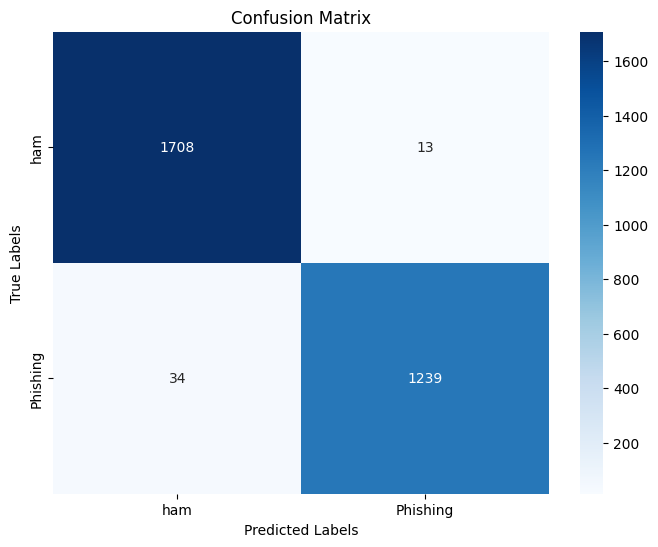

In [131]:
# plotting confusion metrix for loaded_gru_model
plot_confusion_matrix(y_pred=avg_pred_labels_gru_loaded,y_true=test_labels.values)

In [132]:
# evaluating loaded GRU model 
print('Metrics for loaded GRU model\n')

for key,value in calculate_results(avg_pred_labels_gru_loaded,test_labels.values).items(): 
    print(key,value,'\n')

Metrics for loaded GRU model

accuracy 0.9843019372077488 

precision 0.9844362896149723 

recall 0.9843019372077488 

f1 0.9843196189202731 



In [133]:
# classification report of loaded_gru_model 
report_5=classification_report(test_labels.values,avg_pred_labels_gru_loaded)
print(f"classification report for loaded_gru_model \n\n {report_5}")

classification report for loaded_gru_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.99      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [134]:
# calculating other metrices for loaded_gru_model
print('Other metrics for loaded_gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru_loaded).items():
    
    print(key,value,'\n')

Other metrics for loaded_gru_model

False Discovery Rate (FDR) 0.010383386581469648 

False Negative Rate (FNR) 0.02670856245090338 

False Omission Rate (FOR) 0.01951779563719862 

False Positive Rate (FPR) 0.007553747821034283 

Negative Prediction Value (NPV) 0.9804822043628014 



## Comparing models results 

In [135]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,98.329993,98.331839,98.329993,98.330513
bidirectional,97.294589,97.294889,97.294589,97.294728
LSTM,98.363393,98.363304,98.363393,98.362798
GRU,98.430194,98.443629,98.430194,98.431962
Dense,97.828991,97.828556,97.828991,97.828227


In [136]:
cnn_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_dense_model)
other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,1.736385,2.199529,1.621309,1.278327,98.378691
bidirectional,3.144654,3.220738,2.380952,2.324230,97.619048
LSTM,1.658768,2.199529,1.620370,1.220221,98.379630
GRU,1.038339,2.670856,1.951780,0.755375,98.048220
Dense,2.812500,2.278083,1.691949,2.091807,98.308051


In [137]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,98.329993,98.331839,98.329993,98.330513,1.736385,2.199529,1.621309,1.278327,98.378691
bidirectional,97.294589,97.294889,97.294589,97.294728,3.144654,3.220738,2.380952,2.324230,97.619048
LSTM,98.363393,98.363304,98.363393,98.362798,1.658768,2.199529,1.620370,1.220221,98.379630
GRU,98.430194,98.443629,98.430194,98.431962,1.038339,2.670856,1.951780,0.755375,98.048220
Dense,97.828991,97.828556,97.828991,97.828227,2.812500,2.278083,1.691949,2.091807,98.308051


In [184]:
# making a function that plots a bar plot for comparion of metrics between columns 
def plot_bar_plot_of_metric(column_name : str , color : str):
    """
    Plots a bar chart of a specified metric from a DataFrame, sorted in descending order.

    Parameters:
    - column_name (str): The name of the column/metric to plot.
    - color (str): The color code for the bars in the plot (e.g., 'FF5733' for orange).

    Returns:
    - None: Displays the plot directly using matplotlib.

    Example Usage:
    >>> plot_bar_plot_of_metric('False Positive Rate (FPR)', 'FF5733')
    """

    

    ax = all_metrics_df.sort_values(column_name, ascending=False)[column_name].plot(kind='bar', figsize=(9, 8), color=f'#{color}')

    # Adding value labels above each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Adding title and labels
    plt.title(f'Models Sorted Descendingly by {column_name}')
    plt.ylabel(f'{column_name}%', fontsize=12)

    # Adding grid and rotating x-axis labels
    plt.grid()
    plt.xticks(rotation=0)

    # Displaying the plot
    plt.show()

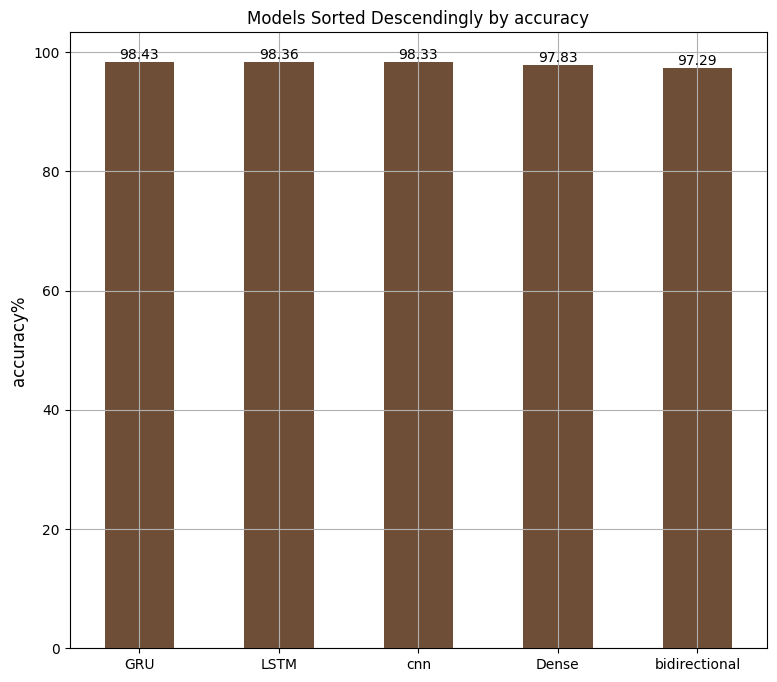

In [186]:
# plotting bar plot for models sorted descendingly by accuracy

plot_bar_plot_of_metric('accuracy','6F4E37')

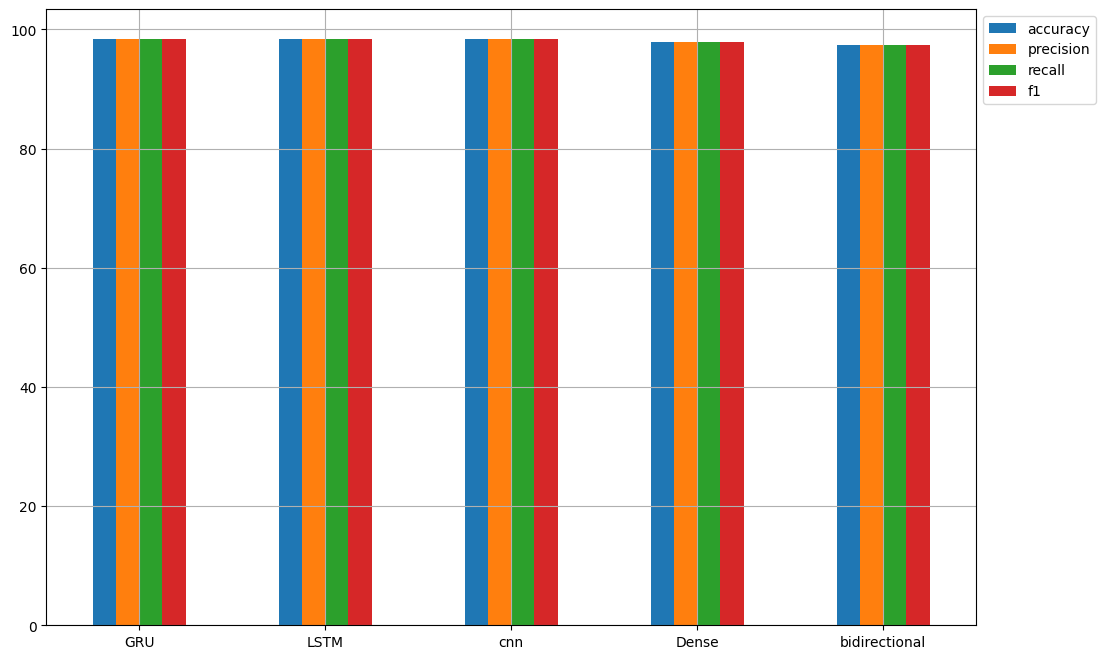

In [139]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

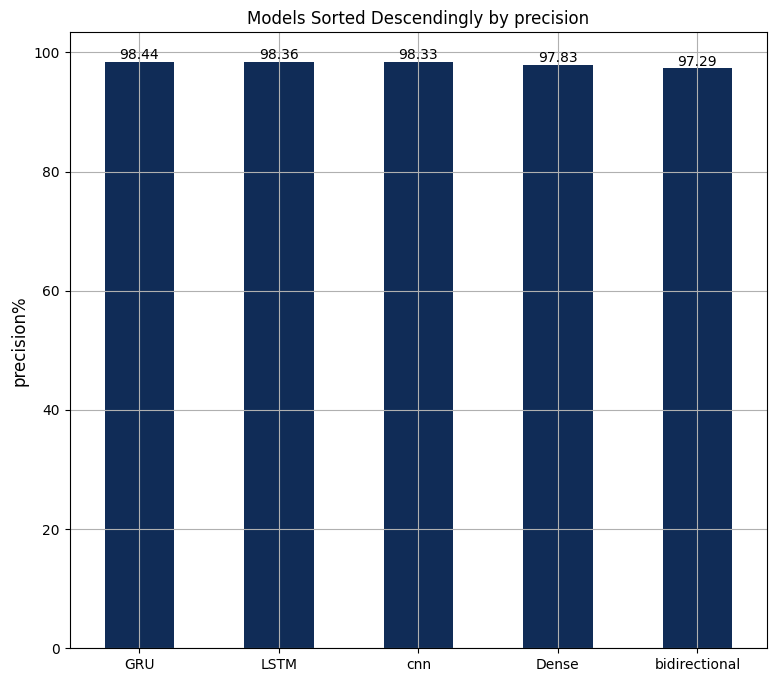

In [187]:
# plotting bar plot for models sorted descendingly by precision
plot_bar_plot_of_metric('precision','102C57')

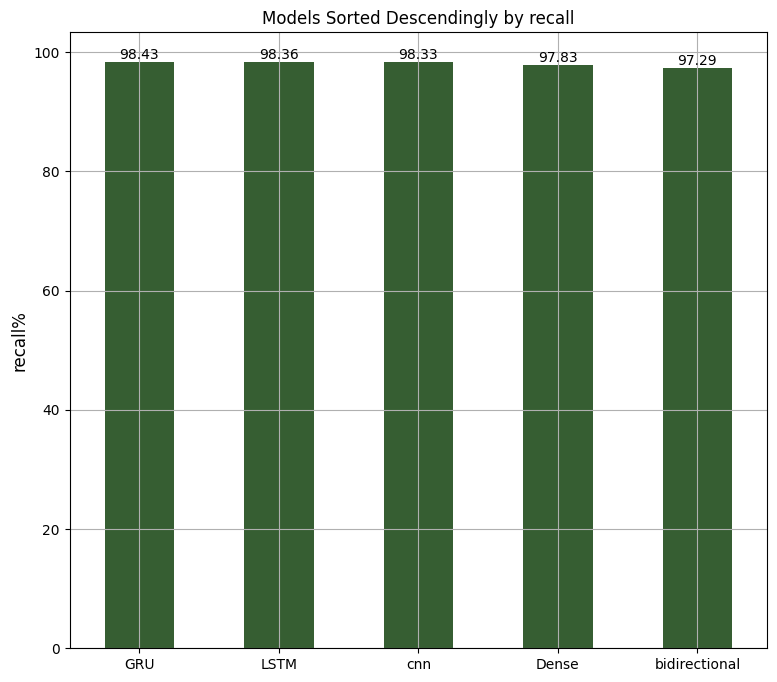

In [188]:
# plotting bar plot for models sorted descendingly by recall 
plot_bar_plot_of_metric('recall','365E32')

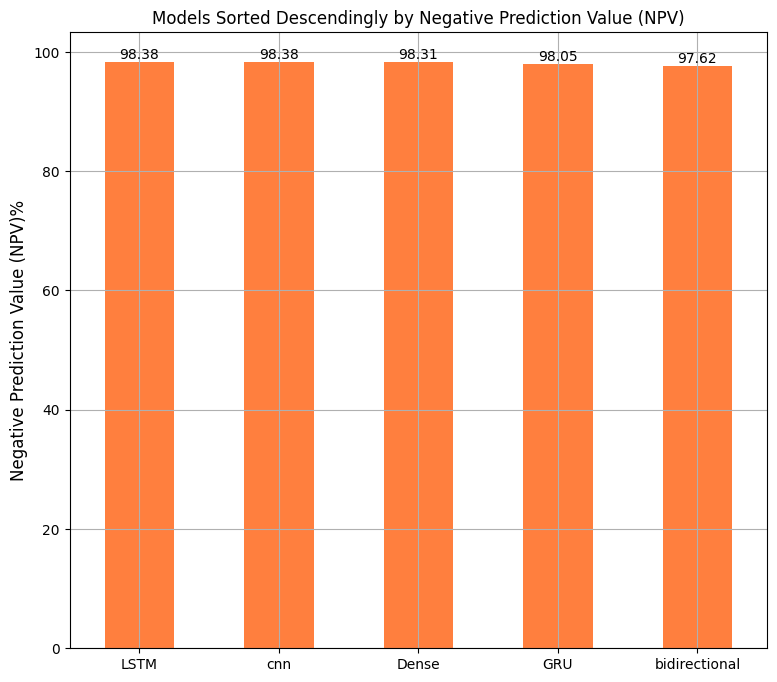

In [191]:
# Plotting bar plot for models sorted descendingly by NPV
plot_bar_plot_of_metric('Negative Prediction Value (NPV)','FF7F3E')

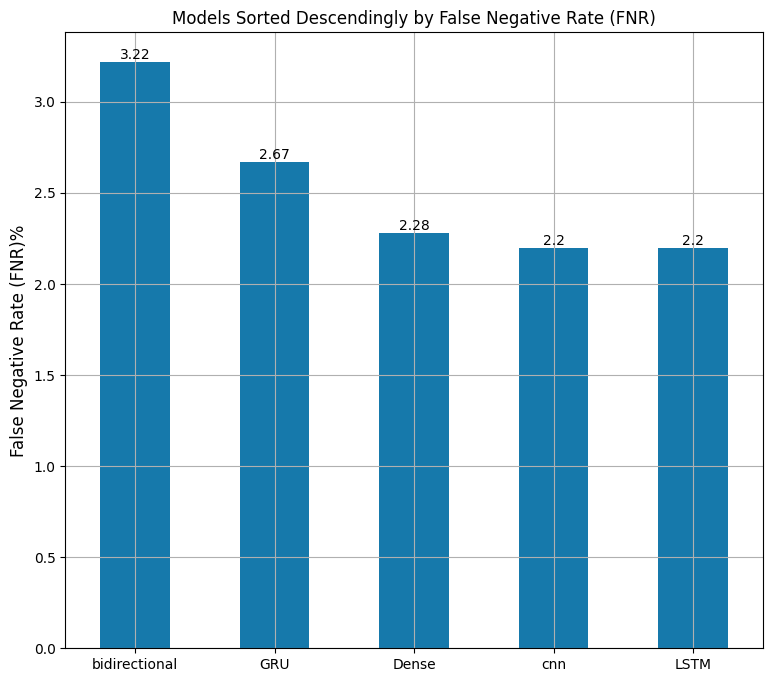

In [192]:
# Plotting bar plot for models sorted descendingly by FNR

plot_bar_plot_of_metric('False Negative Rate (FNR)','1679AB')

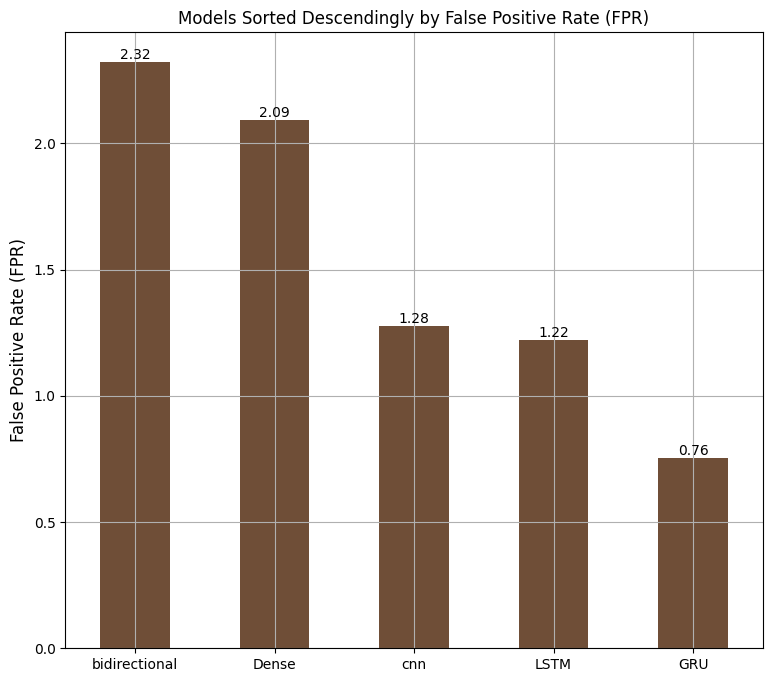

In [145]:
# Plotting bar plot for models sorted descendingly by FPR

plot_bar_plot_of_metric('False Positive Rate (FPR)','6F4E37')

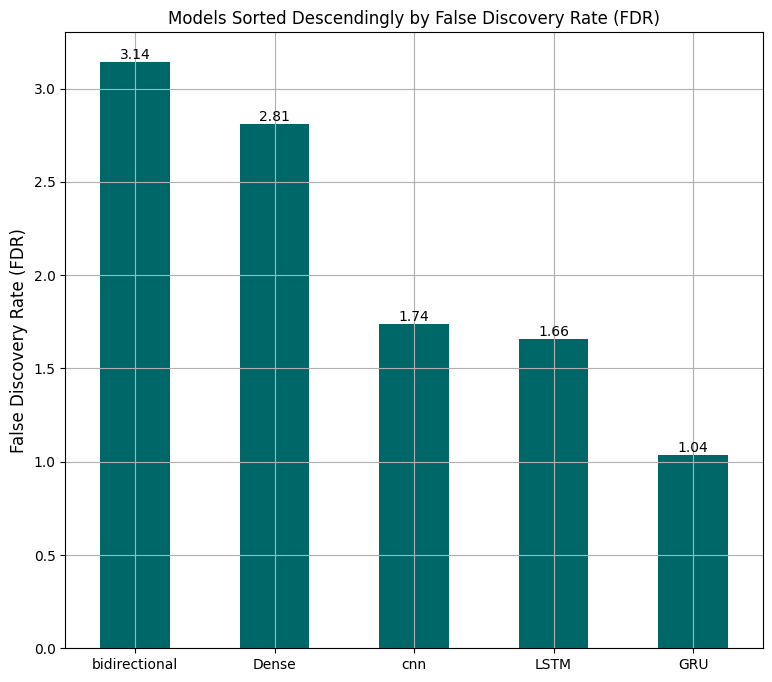

In [146]:
# Plotting bar plot for models sorted descendingly by FDR

plot_bar_plot_of_metric('False Discovery Rate (FDR)','006769')

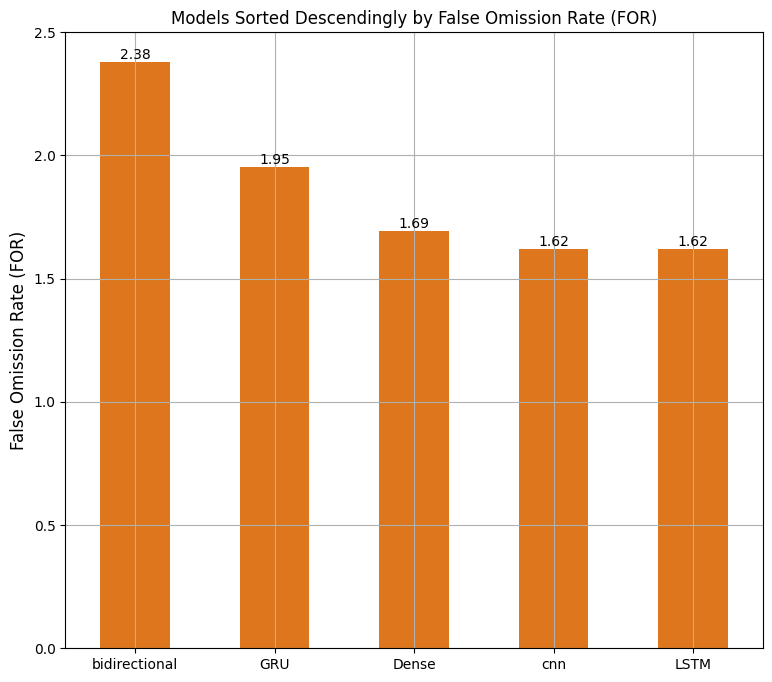

In [147]:
# Plotting bar plot for models sorted descendingly by FOR

plot_bar_plot_of_metric('False Omission Rate (FOR)','DD761C')

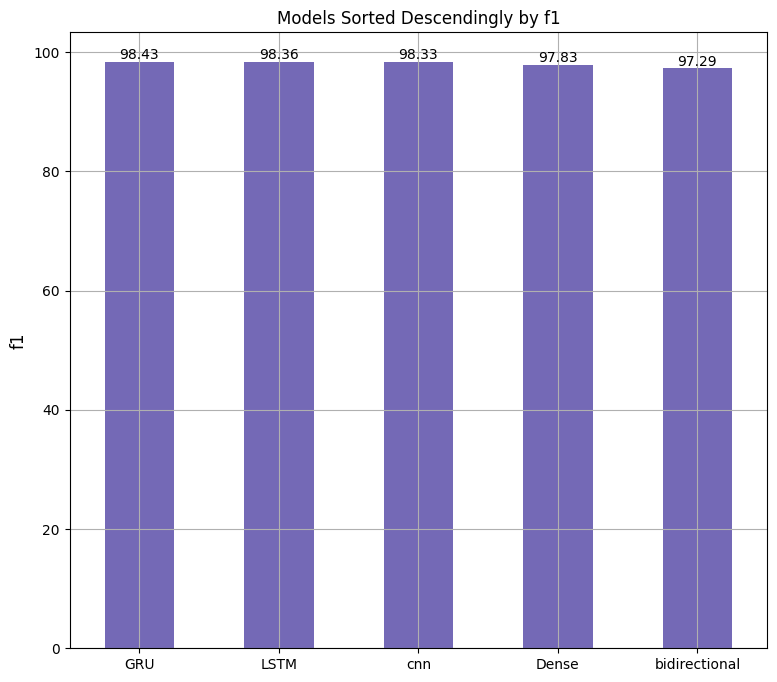

In [148]:
# Plotting bar plot for models sorted descendingly by F1 score 

plot_bar_plot_of_metric('f1','7469B6')

## Comparing prediction time for models 

In [149]:
# taking a sample of messages 
messages_sample=test_text.sample(30)


In [150]:
# creating a function to caculate average prediction time for a model 
import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [151]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.00459906260172526


In [152]:
calculate_pred_time(gru_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Average prediction time for GRU_model for a message of this sample 
 0.002796173095703125


In [153]:
calculate_pred_time(cnn_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.002787629763285319


In [154]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.0027394930521647135


## Finding wrong predictions with heighest prediction probablities 

In [155]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


array([[[3.3242133e-01],
        [1.3241585e-01],
        [1.6936742e-01],
        ...,
        [9.9954563e-01],
        [9.9954563e-01],
        [9.9954563e-01]],

       [[4.6596143e-02],
        [6.6342361e-02],
        [5.8828082e-02],
        ...,
        [1.1526988e-04],
        [1.1527450e-04],
        [1.1527924e-04]],

       [[5.3949453e-02],
        [7.4100215e-03],
        [1.7178531e-03],
        ...,
        [3.9885705e-05],
        [3.9888291e-05],
        [3.9890914e-05]],

       ...,

       [[4.6949458e-01],
        [5.6858605e-01],
        [2.9643500e-01],
        ...,
        [4.4524295e-05],
        [4.3394328e-05],
        [3.5103603e-05]],

       [[1.8964121e-01],
        [6.9575444e-02],
        [3.6783814e-02],
        ...,
        [5.4992957e-05],
        [5.4995056e-05],
        [5.4997097e-05]],

       [[9.2086959e-01],
        [9.9112296e-01],
        [9.9648333e-01],
        ...,
        [9.9950445e-01],
        [9.9950445e-01],
        [9.9950445e-01]]

In [156]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(2994, 1024, 1)

In [157]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(2994, 1)

In [158]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [159]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

,probability
2986,0.997341
3622,0.000312
10529,0.000103
6607,0.000544
7950,0.003002
...,...
319,0.997189
8207,0.000154
3421,0.006991
1808,0.000387


In [160]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [161]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
2986,0.997341,1
3622,0.000312,0
10529,0.000103,0
6607,0.000544,0
7950,0.003002,0
...,...,...
319,0.997189,1
8207,0.000154,0
3421,0.006991,0
1808,0.000387,0


In [162]:
test_text

2986     This is a multi-part message in MIME format\n\...
3622     \n----- Original Message ----- \nFrom: "John H...
10529    shelia.benke@enron.com, donald.black@enron.com...
6607     hey,\n\nAFAIK it isn't hard at all to create\n...
7950     jerry.graves@enron.com, kimberly.watson@enron....
                               ...                        
319      This is a multi-part message in MIME format\n-...
8207     diane.salcido@enron.com, regina.blackshear@enr...
3421     <!-- to unsubscribe or change email format cli...
1808     On Mon, 16 Sep 2002, Stephen D. Williams wrote...
3317     --qzsoft_directmail_seperator\nContent-Type: t...
Name: text, Length: 2994, dtype: object

In [163]:
test_labels

2986     1
3622     0
10529    0
6607     0
7950     0
        ..
319      1
8207     0
3421     0
1808     0
3317     1
Name: phishing, Length: 2994, dtype: int64

In [164]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

,text,phishing
2986,This is a multi-part message in MIME format\n\...,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0
...,...,...
319,This is a multi-part message in MIME format\n-...,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0
3421,<!-- to unsubscribe or change email format cli...,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0


In [165]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,phishing,probability,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997341,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000312,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000103,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000544,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.003002,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997189,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000154,0
3421,<!-- to unsubscribe or change email format cli...,0,0.006991,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000387,0


In [166]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [167]:
test_predictions_df

,text,actual,predicted_probablity,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997341,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000312,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000103,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000544,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.003002,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997189,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000154,0
3421,<!-- to unsubscribe or change email format cli...,0,0.006991,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000387,0


In [168]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [169]:
# how many messages their predicted_labels are  wrong of test_text
print(f'there are {len(mistake_df)} mestakes in precdiction for this model')

47

In [170]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996285,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.995572,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.995467,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.992967,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.987642,1
3957,"For almost a year, we've been working on a new...",0,0.983876,1
3839,\n<http://www.harpercollins.com/hc/scripts/cl...,0,0.972735,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.970516,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.954494,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.929528,1


In [171]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

,text,actual,predicted_probablity,pred_labels
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.732325,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.992967,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.995467,1
3957,"For almost a year, we've been working on a new...",0,0.983876,1
3839,\n<http://www.harpercollins.com/hc/scripts/cl...,0,0.972735,1
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996285,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.929528,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.995572,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.987642,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.954494,1


In [172]:
# how many false_positives
print(f'there are {len(false_positives)} false positive messages')

13

In [173]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996285,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.995572,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.995467,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.992967,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.987642,1
3957,"For almost a year, we've been working on a new...",0,0.983876,1
3839,\n<http://www.harpercollins.com/hc/scripts/cl...,0,0.972735,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.970516,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.954494,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.929528,1


## Testing  False Positives 

In [174]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.996285,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.995572,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.995467,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.992967,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.987642,1
3957,"For almost a year, we've been working on a new...",0,0.983876,1
3839,\n<http://www.harpercollins.com/hc/scripts/cl...,0,0.972735,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.970516,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.954494,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.929528,1


In [175]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

My ideal mailwall will allow message passthrough in many ways:

  - Sender membership on my personal whitelist or any one of 
    many other external whitelists I respect
  - Payment of a small fee (via a website and PayPal link)
  - Demonstration of special per-message effort, either 
    via...
    - a computational challenge (hashcash)
    or
    - other challenge that requires human-level flexibility & 
      followthrough (sender manual whitelisting)
  - Inclusion of a legally-enforceable guarantee that the
    mail is not an unsolicited commercial pitch -- one
    example of this class of guarantee would be a posted
    bond
  - By convincing some analysis software agent of mine that
    I want to see the mail, based on its content and 
    distribution list

There's no need to do only one. Some might overlap; the manual
process for passing a message through might require the assertion
of a legally-enforceable guarantee about the messages' contents.
Passing certain tests once mig

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [176]:
false_negatives 

,text,actual,predicted_probablity,pred_labels
4202,What does it mean to be made in the USA? CNA i...,1,0.001732,0
7319,Best to save it for later then. chinquapin bri...,1,0.017079,0
6965,I think that just might be a little closer to ...,1,0.001438,0
7896,"""After a bit she gave it back to him and allow...",1,0.002233,0
5945,"Check out our $1,000.00 internet challenge!\ta...",1,0.046820,0
7279,[IMAGE] When years old you reach look as good...,1,0.000513,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.003864,0
5335,$7.95 Power HostingLimited Time Offer: Sign u...,1,0.029985,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.000417,0
4590,"Dear Friend,This last summer, our family had a...",1,0.043623,0


In [177]:
# how many false_negatives

len(false_negatives)

34

In [178]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

,text,actual,predicted_probablity,pred_labels
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.000240,0
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000307,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.000417,0
7279,[IMAGE] When years old you reach look as good...,1,0.000513,0
4577,Latest news and information Leasi...,1,0.000691,0
6626,Complain to the management Paul. credible derr...,1,0.000748,0
6965,I think that just might be a little closer to ...,1,0.001438,0
4202,What does it mean to be made in the USA? CNA i...,1,0.001732,0
6948,Guten Tag hier ist eine Zusammenfassung der Ko...,1,0.001946,0
7896,"""After a bit she gave it back to him and allow...",1,0.002233,0


In [179]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

,text,actual,predicted_probablity,pred_labels
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.000240,0
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000307,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.000417,0
7279,[IMAGE] When years old you reach look as good...,1,0.000513,0
4577,Latest news and information Leasi...,1,0.000691,0
6626,Complain to the management Paul. credible derr...,1,0.000748,0
6965,I think that just might be a little closer to ...,1,0.001438,0
4202,What does it mean to be made in the USA? CNA i...,1,0.001732,0
6948,Guten Tag hier ist eine Zusammenfassung der Ko...,1,0.001946,0
7896,"""After a bit she gave it back to him and allow...",1,0.002233,0


In [180]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

The floorboards creaked in back of him. chain botanic Wasn't that how the story was supposed to go? She raised her hands to her forehead and pressed them against the wounds blotting them. Housewives arranged their schedules around the afternoon soaps. You could get by on aspirin or Empirin now. Came unplugged. Paul marvelled at how composed she sounded how pleasant. Trouble was the nasty thing had a way of escaping and coming back time after time in one form or another. The plot was melodramatic but well constructed in its own modest way quite amusing. bemoan 

 ####################################################################################################
Sports Illustrated loook at Dogs world OFFBEAT late night 

 ####################################################################################################
Updated May 9, 2002 ...READ THIS! YOU'LL BE HAPPY YOU DID! A recent survey by Nielsen/Netratings says that "The Internetpopulation is rapidly approaching a 'Half a Bill

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 